# Check training result

In [1]:
TEST_CODE = "1560862315.84624"
CHOSEN_EPOCH = 80

MODEL_PATH = "../log/{}/models/epoch_{}".format(TEST_CODE, CHOSEN_EPOCH)
LOG_PATH = "../log/{}/log.txt".format(TEST_CODE)

In [2]:
log = open(LOG_PATH).readlines()

Parameter

In [3]:
log[0]

"Namespace(base_lr=0.0005, batch_size=500, decay_epoch_step=25, display_step=1, grad_clip=False, hidden_neuron=100, lambda_value=1, optimizer_method='Adam', random_seed=1000, save_step=5, train_epoch=100)\n"

In [4]:
train_log = log[1::2]
test_log = log[2::2]

In [5]:
train_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in train_log][:-1]
test_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in test_log]
test_RMSE = [float(line.split('\t')[2].replace("RMSE = ","")) for line in test_log]

In [6]:
n_train = int(138493 * 0.9)
n_test = int(138493 * 0.1)

train_cost = [x/n_train for x in train_cost]
test_cost = [x/n_test for x in test_cost]

## Plot

In [7]:
import matplotlib.pyplot as plt

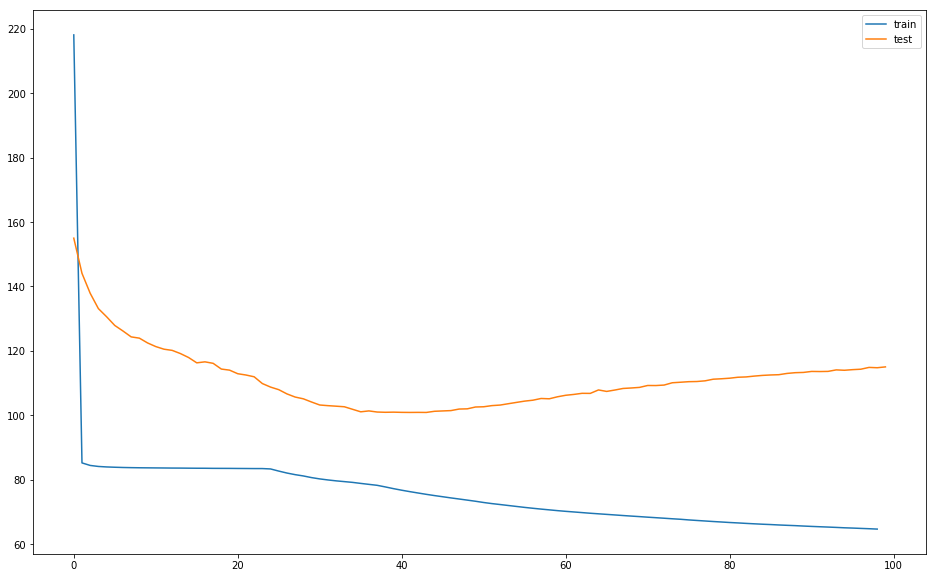

In [8]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(train_cost)), train_cost, label="train")
plt.plot(range(0, len(test_cost)), test_cost, label="test")
plt.legend()

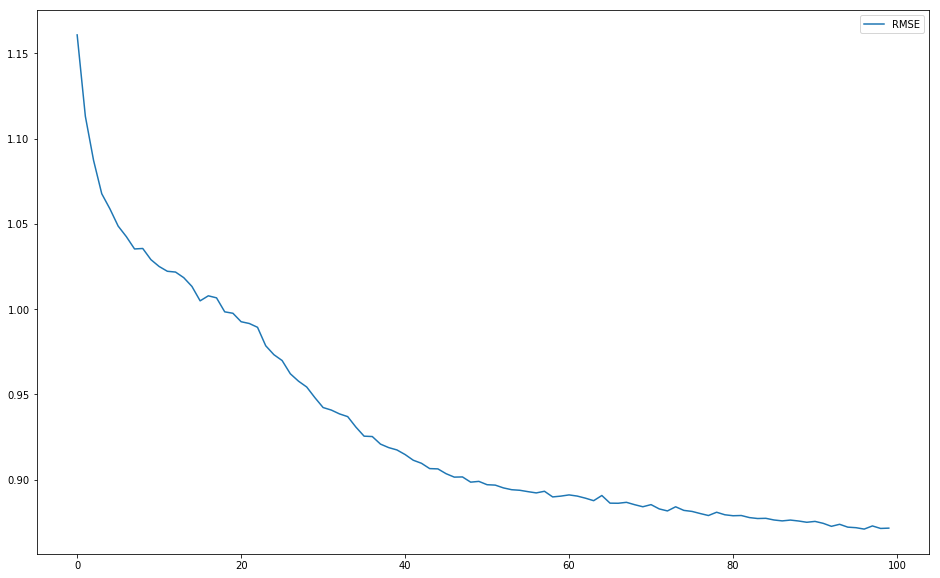

In [9]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(test_RMSE)), test_RMSE, label="RMSE")
plt.legend()

# Model

In [10]:
class Args:
    
    def __init__(self):
        self.hidden_neuron = 100
        self.lambda_value = 1.0
        
        self.train_epoch = 100
        self.batch_size = 200
        
        self.optimizer_method = 'Adam' # 'Adam','RMSProp'
        self.grad_clip = False
        self.base_lr = 0.003
        self.decay_epoch_step = 50
        
        self.random_seed = 1000
        self.display_step = 1
        self.save_step = 5
        
    def __str__(self):
        return "hidden_neuron : {}\nlambda_value : {}\ntrain_epoch : {}\nbatch_size : {}\noptimizer_method : {}\ngrad_clip : {}\nbase_lr : {}\ndecay_epoch_step : {}\nrandom_seed : {}\ndisplay_step : {}\n".format(
            self.hidden_neuron,
            self.lambda_value,
            self.train_epoch,
            self.batch_size,
            self.optimizer_method,
            self.grad_clip,
            self.base_lr,
            self.decay_epoch_step,
            self.random_seed,
            self.display_step,
            self.save_step)

args = Args()

In [11]:
import pickle
import os

class Logger:

    def set_default_filename(self, filename):
        self.default_filename = filename

    def create_session_folder(self, path):
        try:  
            os.makedirs(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
        else:  
            print ("     ===> Successfully created the directory %s \n" % path)

    def log(self, text):
        with open(self.default_filename, 'a') as f:
            f.writelines(text)
            f.write("\n")

    def save_model(self, model, filename):
        pickle.dump(model, open(filename, 'wb'))
    
    

In [12]:
import tensorflow as tf
import time
import numpy as np
import os
import math
from datetime import datetime
from scipy.sparse import lil_matrix, csr_matrix, vstack
from tqdm import tqdm

class AutoRec():
    def __init__(self, sess, args,
                 num_users, num_items,
                 R, mask_R, train_R, train_mask_R, test_R, test_mask_R, num_train_ratings, num_test_ratings,
                 user_train_set, item_train_set, user_test_set, item_test_set):

        self.sess = sess
        self.args = args

        self.num_users = num_users
        self.num_items = num_items

        self.R = R
        self.mask_R = mask_R
        self.train_R = train_R
        self.train_mask_R = train_mask_R
        self.test_r = test_R
        self.test_mask_R = test_mask_R
        self.num_train_ratings = num_train_ratings
        self.num_test_ratings = num_test_ratings

        self.user_train_set = user_train_set
        self.item_train_set = item_train_set
        self.user_test_set = user_test_set
        self.item_test_set = item_test_set

        self.hidden_neuron = args.hidden_neuron
        self.train_epoch = args.train_epoch
        self.batch_size = args.batch_size
        self.num_batch = int(
            math.ceil(self.num_users / float(self.batch_size)))

        self.base_lr = args.base_lr
        self.optimizer_method = args.optimizer_method
        self.display_step = args.display_step
        self.random_seed = args.random_seed

        self.global_step = tf.Variable(0, trainable=False)
        self.decay_epoch_step = args.decay_epoch_step
        self.decay_step = self.decay_epoch_step * self.num_batch
        self.lr = tf.train.exponential_decay(self.base_lr, self.global_step,
                                             self.decay_step, 0.96, staircase=True)
        self.lambda_value = args.lambda_value

        self.train_cost_list = []
        self.test_cost_list = []
        self.test_rmse_list = []

        self.grad_clip = args.grad_clip
        
#         self.timestamp = str(datetime.timestamp(datetime.now()))
#         self.logger = Logger()
#         self.session_log_path = "../log/{}/".format(self.timestamp)
#         self.logger.create_session_folder(self.session_log_path)
#         self.logger.set_default_filename(self.session_log_path + "log.txt")

    def run(self):
        
        # Log parameters
        self.logger.log(str(self.args))
        self.prepare_model()
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        for epoch_itr in (range(self.train_epoch)):
            
            self.train_model(epoch_itr)
            self.test_model(epoch_itr)
            
            # Save the variables to disk.
            if epoch_itr % self.save_step == 0:
                self.saver.save(self.sess, self.session_log_path + "models/epoch_{}".format(epoch_itr))
            
        self.make_records()


    def prepare_model(self):
        self.input_R = tf.placeholder(dtype=tf.float32, shape=[
                                      None, self.num_items], name="input_R")
        self.input_mask_R = tf.placeholder(
            dtype=tf.float32, shape=[None, self.num_items], name="input_mask_R")

        V = tf.get_variable(name="V", initializer=tf.truncated_normal(shape=[self.num_items, self.hidden_neuron],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        W = tf.get_variable(name="W", initializer=tf.truncated_normal(shape=[self.hidden_neuron, self.num_items],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        mu = tf.get_variable(name="mu", initializer=tf.zeros(
            shape=self.hidden_neuron), dtype=tf.float32)
        b = tf.get_variable(name="b", initializer=tf.zeros(
            shape=self.num_items), dtype=tf.float32)

        pre_Encoder = tf.matmul(self.input_R, V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        
        pre_Decoder = tf.matmul(self.Encoder, W) + b
        self.decoder = tf.identity(pre_Decoder)

        pre_rec_cost = tf.multiply(
            (self.input_R - self.decoder), self.input_mask_R)
        rec_cost = tf.square(self.l2_norm(pre_rec_cost))
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost

        self.cost = rec_cost + reg_cost

        if self.optimizer_method == "Adam":
            optimizer = tf.train.AdamOptimizer(self.lr)
        elif self.optimizer_method == "RMSProp":
            optimizer = tf.train.RMSPropOptimizer(self.lr)
        else:
            raise ValueError("Optimizer Key ERROR")

        if self.grad_clip:
            gvs = optimizer.compute_gradients(self.cost)
            capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var)
                          for grad, var in gvs]
            self.optimizer = optimizer.apply_gradients(
                capped_gvs, global_step=self.global_step)
        else:
            self.optimizer = optimizer.minimize(
                self.cost, global_step=self.global_step)
            
        self.saver = tf.train.Saver(max_to_keep=None)

    def train_model(self, itr):
        start_time = time.time()
        random_perm_doc_idx = np.random.permutation(self.num_users)

        batch_cost = 0
        for i in tqdm(range(self.num_batch)):

            if i >= self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size:]
            else:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size: (i + 1) * self.batch_size]

            _, cost = self.sess.run(
                [self.optimizer, self.cost],
                feed_dict={self.input_R: self.train_R[batch_set_idx, :].todense(),
                           self.input_mask_R: self.train_mask_R[batch_set_idx, :].todense()})

            batch_cost = batch_cost + cost

        self.train_cost_list.append(batch_cost)

        if (itr + 1) % self.display_step == 0:
            self.logger.log(
                "Training Epoch {}\tTotal cost = {:.2f}\tElapsed time : {} sec".format(
                    itr, batch_cost, (time.time() - start_time)))
            
            print(
                "===== Training =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "Elapsed time : {} sec\n".format(
                    itr, batch_cost, (time.time() - start_time)))

    def test_model(self, itr):
        start_time = time.time()

        batch_cost = 0
        numerator = 0
        
        for i in tqdm(range(self.num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: self.test_r[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: self.test_mask_R[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost

            # Make prediction if need to show
            if (itr + 1) % self.display_step == 0:

                batch_predict_r = csr_matrix(decoder.clip(min=1, max=5))

                # Some statistic
                predicted_rating_delta = batch_predict_r - self.test_r[batch_start_idx:batch_stop_idx]
                pre_numerator = self.test_mask_R[batch_start_idx:batch_stop_idx].multiply(predicted_rating_delta)
                numerator += np.sum(pre_numerator.data ** 2)

        self.test_cost_list.append(batch_cost)

        # Make prediction if need to show
        if (itr + 1) % self.display_step == 0:

            denominator = self.num_test_ratings
            RMSE = np.sqrt(numerator / float(denominator))
            self.test_rmse_list.append(RMSE)

            self.logger.log(
                "Testing Epoch {}\tTotal cost = {:.2f}\tRMSE = {:.5f}\tElapsed time : {} sec".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

            print(
                "===== Testing =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "RMSE = {:.5f} \t Elapsed time : {} sec\n".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

    def make_records(self):

        basic_info = self.session_log_path + "basic_info.txt"
        train_record = self.session_log_path + "train_record.txt"
        test_record = self.session_log_path + "test_record.txt"

        with open(train_record, 'w') as f:
            f.write(str("cost:"))
            f.write('\t')
            for itr in range(len(self.train_cost_list)):
                f.write(str(self.train_cost_list[itr]))
                f.write('\t')
            f.write('\n')

        with open(test_record, 'w') as g:
            g.write(str("cost:"))
            g.write('\t')
            for itr in range(len(self.test_cost_list)):
                g.write(str(self.test_cost_list[itr]))
                g.write('\t')
            g.write('\n')

            g.write(str("RMSE:"))
            for itr in range(len(self.test_rmse_list)):
                g.write(str(self.test_rmse_list[itr]))
                g.write('\t')
            g.write('\n')

        with open(basic_info, 'w') as h:
            h.write(str(self.args))

    def l2_norm(self, tensor):
        return tf.sqrt(tf.reduce_sum(tf.square(tensor)))

    
    # ============  CUSTOM FOR EVALUATION  ======================
    
    def custom_run(self):
        
        # Log parameters
        self.prepare_model()
        
#         init = tf.global_variables_initializer()
#         self.sess.run(init)
        

    def predict(self, rating, mask_rating):

        batch_cost = 0
        predict_r = csr_matrix((0, rating.shape[1]))
        num_batch = int(math.ceil(rating.shape[0] / float(self.batch_size)))
        
        for i in tqdm(range(num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: rating[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: mask_rating[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost
            batch_predict_r = csr_matrix(decoder.clip(min=1, max=5)) 
            predict_r = vstack([predict_r, batch_predict_r])
            
#             print(predict_r.nonzero())
#             input()
            
        return predict_r, batch_cost

## Load dataset

In [13]:
filename = "../data/intersect-20m/preprocessed_autorec_dataset_test"
R, mask_R, train_R, train_mask_R, eval_R, eval_mask_R, n_train_R, n_eval_R, train_users_idx, train_items_idx, eval_users_idx, eval_items_idx = pickle.load(open(filename, 'rb'))

## Prepare restore model

In [14]:
# Random seeding
tf.set_random_seed(args.random_seed)
np.random.seed(args.random_seed)

# Detail about dataset
path = "data/intersect-20m"
num_users = 13850
num_items = 15085
train_ratio = 0.9

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [15]:
sess = tf.Session(config=config)

model = AutoRec(sess, args,
                  num_users, num_items,
                  None, None, None, None, None, None,
                  None, None, None, None, None, None)

model.custom_run()

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
model.saver = tf.train.import_meta_graph(MODEL_PATH + ".meta")
model.saver.restore(sess, MODEL_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../log/1560862315.84624/models/epoch_80


## Make prediction

In [17]:
prediction, cost = model.predict(train_R, train_mask_R)

100%|██████████| 70/70 [01:39<00:00,  1.99s/it]


In [18]:
import pandas as pd

prediction_df = pd.DataFrame(prediction.todense())

In [19]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,...,15075,15076,15077,15078,15079,15080,15081,15082,15083,15084
0,2.570650,2.560344,3.181075,2.204818,2.400665,3.058847,2.710044,2.353100,3.652023,2.294132,...,2.535710,3.133242,3.542014,1.306954,2.220194,1.445551,2.768342,3.789418,2.688917,2.631226
1,2.718571,2.567676,3.250449,2.231879,2.434323,2.370953,2.720922,2.329411,3.583902,2.301431,...,2.272655,3.167191,3.610968,1.310954,2.215945,1.482405,2.850169,3.703087,2.715678,2.760154
2,2.633743,2.514753,3.148633,2.175483,2.366964,2.716937,2.671452,2.308281,3.568528,2.265564,...,2.438512,3.065792,3.455466,1.286161,2.154471,1.439545,2.745330,3.574396,2.636008,2.634865
3,2.545077,2.572297,3.183889,2.168593,2.406959,2.716986,2.686912,2.344575,3.616184,2.259491,...,2.325114,3.103079,3.527058,1.295845,2.221293,1.462432,2.824575,3.735273,2.698123,2.655424
4,2.652927,2.563729,3.183248,2.179994,2.399709,2.697564,2.677035,2.325392,3.556769,2.279705,...,2.347378,3.127757,3.607097,1.302213,2.199176,1.449002,2.820024,3.847120,2.708302,2.697901
5,2.653732,2.572278,3.169796,2.235092,2.407801,2.980100,2.734920,2.377463,3.781183,2.320333,...,2.569823,3.114575,3.514432,1.301685,2.200117,1.458912,2.795564,3.769973,2.665084,2.661248
6,2.571324,2.521718,3.137555,2.195481,2.371240,3.090053,2.664402,2.346007,3.704862,2.286653,...,2.464121,3.071357,3.517697,1.290310,2.180780,1.429216,2.756349,3.892419,2.648761,2.608427
7,2.560122,2.595850,3.166255,2.209084,2.398664,3.106735,2.710560,2.396988,3.591638,2.299106,...,2.539848,3.119405,3.421346,1.308226,2.220235,1.447387,2.778792,3.849754,2.704615,2.592311
8,2.802297,2.686632,3.287014,2.293518,2.497398,3.130498,2.801615,2.466868,3.869555,2.392389,...,2.592839,3.243670,3.672663,1.334221,2.272918,1.495659,2.953467,3.927512,2.798581,2.745510
9,2.609395,2.598864,3.200335,2.160060,2.407879,2.808334,2.744035,2.417056,3.625321,2.313854,...,2.443585,3.107217,3.270303,1.313672,2.231111,1.464065,2.861335,3.712752,2.717443,2.647204


## Ground truth

In [20]:
truth_df = pd.DataFrame(eval_R.todense())

# Sort rating, find intersection

In [21]:
def getIndices(user, qua, offset):
    return set(prediction_df.iloc[user].sort_values(ascending=False)[offset:offset+qua].index)

def get_top_suggestion(user, n, offset):
    return prediction_df.iloc[user].sort_values(ascending=False)[offset:offset + n]

def get_top_truth(user, n, offset):
    top_truth = truth_df.iloc[user].sort_values(ascending=False)[offset:offset + n]
    return top_truth[top_truth > 0]

def get_intersect_pred_truth(pred, truth, k):
    pred_item_set = set(pred.index)
    truth_item_set = set(truth.index)
    
    return pred_item_set.intersection(truth_item_set)

def check_precision_at_k(sample_user, k):
    
    pred = get_top_suggestion(sample_user, k, 0)
    truth = get_top_truth(sample_user, k, 0)
    
    intersect = get_intersect_pred_truth(pred, truth, k)
    
    if len(truth) > 0 :
        return intersect, len(intersect) / len(truth)
    else:
        return None, 0

## Manual check prec at K

In [22]:
from tqdm import tqdm

prec = []
for i in tqdm(range(0, 13850)):
    _, p = check_precision_at_k(i, 10)
    prec.append(p)
    
prec

100%|██████████| 13850/13850 [01:07<00:00, 206.28it/s]


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.3333333333333333,
 0.14285714285714285,
 0.0,
 0.2,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.125,
 0.0,
 0.1,
 0.1,
 0.0,
 0.0,
 0.0,
 0.1,
 0.1,
 0.14285714285714285,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.25,
 0.5,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2857142857142857,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.2,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.125,
 0.2,
 0.0,
 0.0,
 

In [23]:
import numpy as np

np.average(prec)

0.027524984241590736

In [24]:
isect = getIndices(np.random.randint(1,2000),10, 0)
for i in range(5):
    st = getIndices(np.random.randint(1,2000),10, 0)
    print(st)
    isect = isect.intersection(st)
    
print(sorted(isect),len(isect))

{11394, 2435, 1511, 2216, 6671, 13106, 11316, 9657, 5979, 13566}
{9635, 7909, 9657, 654, 8498, 10452, 11316, 11958, 4569, 13566}
{519, 11466, 7147, 3085, 8784, 530, 14970, 11958, 10586, 1724}
{2819, 11466, 3085, 4671, 8784, 9553, 11895, 5371, 7742, 671}
{1511, 41, 3085, 6672, 13106, 5817, 8025, 14652, 7742, 671}
[] 0


## Get movie description

In [25]:
movies = open("../../GDP-RippleNet/data/movie/moviesIdx.txt").readlines()

dict_entities = {}
for movie in movies:
    x = movie.strip().split()
    movie_id = x[0]
    movie_name = x[1].replace('http://dbpedia.org/resource/', '').replace("_", " ")
    dict_entities[movie_id] = movie_name

def describe(item):
    display(get_title(item))
    rating_by_people = people_rated_for(item)
    display("{} rated with average: {}".format(len(rating_by_people), get_average_rating(rating_by_people)))
#     display(rating_by_people)
    display(get_all_ratings(item))
    plot_prediction_ratings(item)

def people_rated_for(item):
    users = train_R[:, item].nonzero()[0]
    return [(user, get_rating(user, item)) for user in users]

def get_average_rating(user_ratings):
    n = 0
    for rating in user_ratings:
        n += rating[1]
    return n / len(user_ratings)

def get_rating(user, item):
    return R[user, item].item()

def get_title(item):
    return dict_entities[str(item)]

def get_all_ratings(item, size=25):
    return prediction_df.iloc[:size, item]

def plot_prediction_ratings(item):
    y = prediction_df.loc[:, item]
    plt.figure(figsize=(16,10))
    plt.plot(range(0, len(y)), y)

'Run of the Arrow'

'4445 rated with average: 4.320584926884139'

0     4.776715
1     4.441036
2     3.679615
3     4.468681
4     4.261963
5     4.101122
6     4.369717
7     4.060070
8     4.181397
9     4.350286
10    4.442394
11    3.807468
12    4.348988
13    4.211060
14    4.658206
15    4.427357
16    4.398775
17    4.204830
18    4.381942
19    4.362875
20    4.630927
21    4.064443
22    4.131683
23    3.971581
24    4.523517
Name: 11316, dtype: float64

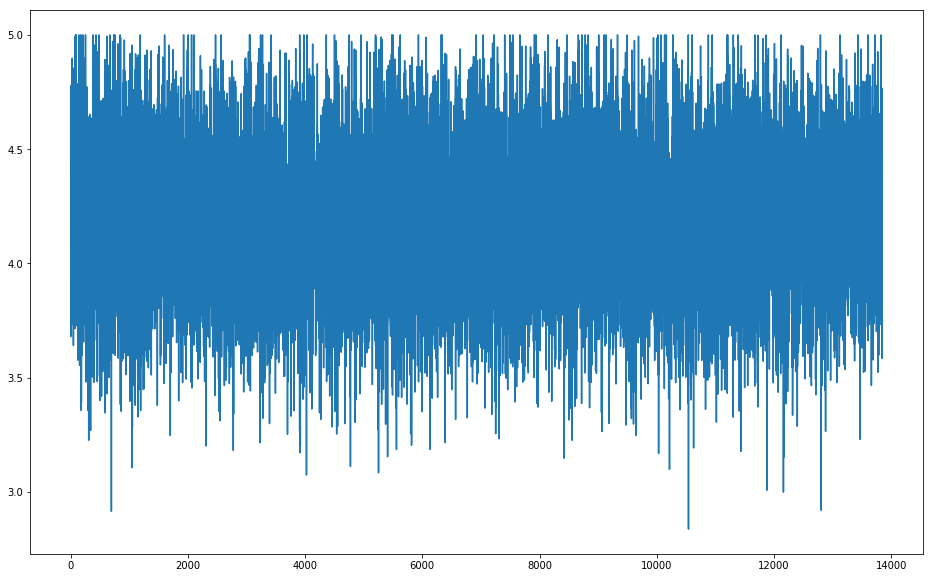

In [26]:
describe(11316)